# Setup

In [1]:
# This is a setup snippet!
from __future__ import print_function, unicode_literals, division
import numpy as np
import os
import warnings

warnings.filterwarnings(action='ignore', message='^inernal gelsd')

np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'unsupervised_learning'

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID, fig_id)

if not os.path.isdir(os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)):
    os.mkdir(os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID))

def save_fig(fig_id, tight_layout=True):
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + '.png', format='png', dpi=300)

# Projection methods

$X = U \cdot \Sigma \cdot V^T$

In [2]:
np.random.seed(42)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
# the svd() returns U, s, and Vt

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0] # (Vt)t = V, first two dimemsion
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)  # get the n dimension, n is the number of dimension
S[:n, :n] = np.diag(s)

In [5]:
# np.allclose: check if the two matrix is the same
# verify svd result
np.allclose(X_centered, U.dot(S).dot(Vt))  

True

$X_{recovered} = X_{d-proj} \cdot W_d^T$, $$$$
$W_d$ is the the matrix contraining the firt d principlai components, i.e. first d columns of $V$

In [6]:
W2T = Vt.T[:, :2]
X2D_using_svd = X_centered.dot(W2T)

# PCA using Scikit-Learn

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [8]:
X2D[:5]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852]])

In [9]:
X2D_using_svd[:5]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852]])

In [10]:
np.allclose(X2D, X2D_using_svd)

True

In [11]:
# recover the 3D points projected on the plane
X3D_inv = pca.inverse_transform(X2D)

In [12]:
# there are some loss of info
np.allclose(X3D_inv, X)

False

In [13]:
# compute the reconstruction error
# axis = 1 computes the error for each instance along all dimension
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.009421417196957218

In [14]:
X3D_inv_using_svd = X2D.dot(Vt[:2, :])

In [15]:
# the reconstructions from both methods are not identical 
# because sklearn's PCA automatically takes care of reversing the mean centering
#but if we substract the mean, we get the same reconstruction

np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [16]:
# the PCA objects gives access to the principal components computed using the SVD method
pca.components_

array([[-0.95250178, -0.24902446, -0.17529172],
       [ 0.29267159, -0.9076305 , -0.30091563]])

In [17]:
# compared to the first two principal component computed using the SVD method

Vt[:2]

array([[-0.95250178, -0.24902446, -0.17529172],
       [ 0.29267159, -0.9076305 , -0.30091563]])

In [18]:
Vt

array([[-0.95250178, -0.24902446, -0.17529172],
       [ 0.29267159, -0.9076305 , -0.30091563],
       [ 0.08416476,  0.33792558, -0.93740205]])

In [19]:
pca.explained_variance_ratio_

array([0.85406025, 0.13622918])

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.009710567616013632

In [21]:
# here is how to compute explained variance using SVD approach

np.square(s) / np.square(s).sum()

array([0.85406025, 0.13622918, 0.00971057])

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Saving figure dataset_3d_plot


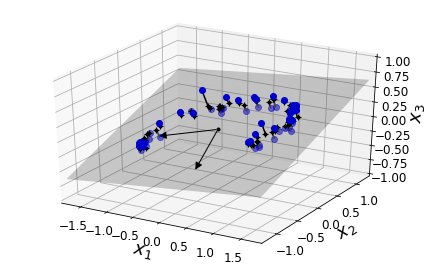

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], 'bo', alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color='k')
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]], [0, C[0, 1]], [0, C[0, 2]], mutation_scale=15, 
                      lw=1, arrowstyle='-|>', color='k'))
ax.add_artist(Arrow3D([0, C[1, 0]], [0, C[1, 1]], [0, C[1, 2]], mutation_scale=15, 
                      lw=1, arrowstyle='-|>', color='k'))
ax.plot([0], [0], [0], 'k.')

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], 'k-')
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], 'k-', 
                color='#505050')
        
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], 'k+')
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], 'k.')
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], 'bo')
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig('dataset_3d_plot')
plt.show()

Saving figure dataset_2d_plot


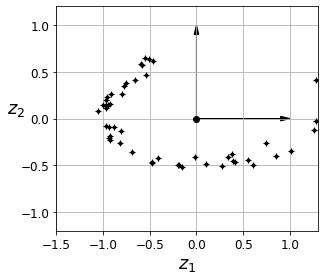

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], 'k+')
ax.plot(X2D[:, 0], X2D[:, 1], 'k.')
ax.plot([0], [0], 'ko')
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

# Manifold learning

In [26]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


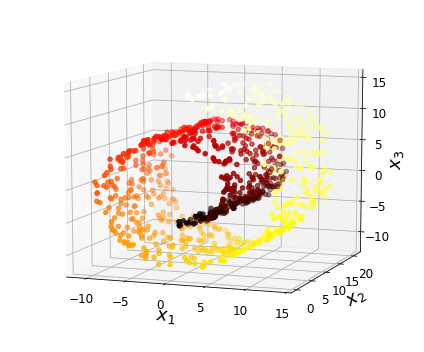

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_xlim(axes[2:4])
ax.set_xlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

Saving figure squished_swiss_roll_plot


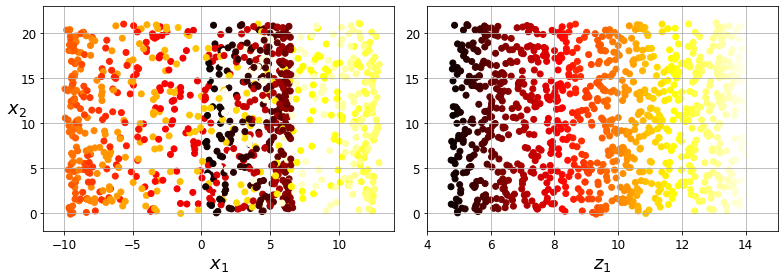

In [28]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
# plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

Saving figure manifold_decision_boundary_plot1


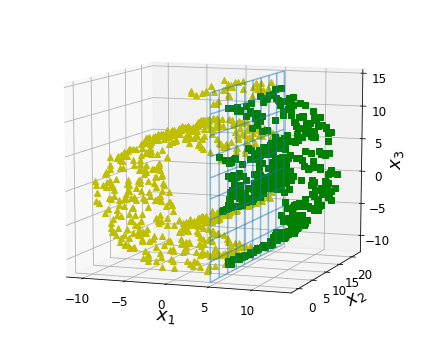

Saving figure manifold_decision_boundary_plot2


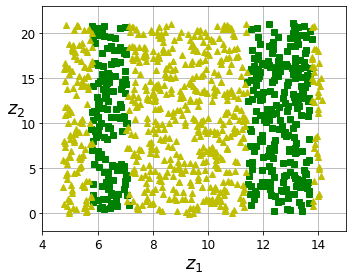

Saving figure manifold_decision_boundary_plot3


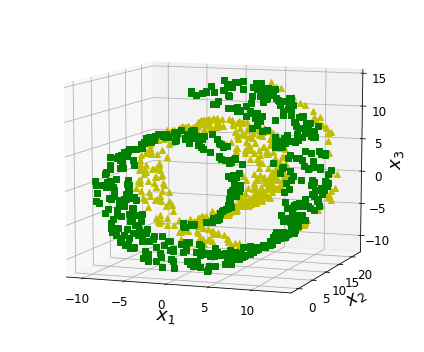

Saving figure manifold_decision_boundary_plot4


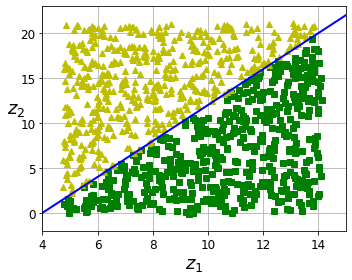

In [29]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')
positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()


fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
ax.grid(True)
ax.plot(t[positive_class], X[positive_class, 1], 'gs')
ax.plot(t[~positive_class], X[~positive_class, 1], 'y^')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([4, 15, axes[2], axes[3]])

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')
positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
ax.grid(True)
ax.plot(t[positive_class], X[positive_class, 1], 'gs')
ax.plot(t[~positive_class], X[~positive_class, 1], 'y^')
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([4, 15, axes[2], axes[3]])

save_fig("manifold_decision_boundary_plot4")
plt.show()

# PCA

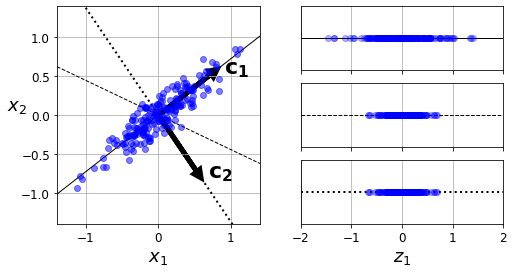

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]]))  # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u2.reshape(-1, 1))

plt.figure(figsize=(8,4))
# plot subplot that subplot has different sizes, rowspan: this subplot takes 3 rows
plt.subplot2grid((3,2), (0, 0), rowspan=3)  
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid(True)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, 
          head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, 
          head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)

plt.subplot2grid((3,2), (0, 1)) 
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.axis([-2, 2, -1, 1])
plt.grid(True)
plt.gca().get_yaxis().set_ticks([])  # set empty ticks
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()


# MNIST compression

In [31]:
from six.moves import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [32]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

In [35]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [36]:
pca.n_components_

154

In [37]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295709

In [38]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [39]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros([size, size * n_empty]))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

Saving figure mnist_compression_plot


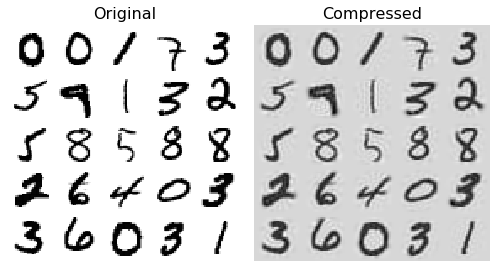

In [40]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [41]:
X_reduced_pca = X_reduced

## Incremental PCA

In [42]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):  # progress bar
    print('.', end='')
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [43]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

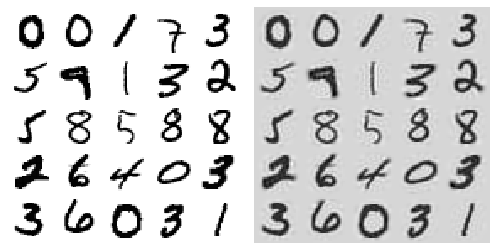

In [44]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [45]:
X_reduced_inc_pca = X_reduced

In [46]:
# the pca and incremental pca have the same mean
np.allclose(pca.mean_, inc_pca.mean_)

True

In [47]:
# but they are not exactly identical
# incremental pca gives a very good approximate solution

np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Using memmap()

In [48]:
# create memmap structure and copy MNIST data into it

filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [49]:
del X_mm

In [50]:
# another program would load the date and use it for training

X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [51]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Time complexity

In [52]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components)
    rnd_pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
    
    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print('    {}: {:.1f} seconds'.format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.0 seconds
    IncrementalPCA: 11.8 seconds
    PCA: 1.6 seconds
n_components = 10
    PCA: 2.0 seconds
    IncrementalPCA: 12.8 seconds
    PCA: 1.9 seconds
n_components = 154
    PCA: 6.4 seconds
    IncrementalPCA: 12.9 seconds
    PCA: 6.2 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

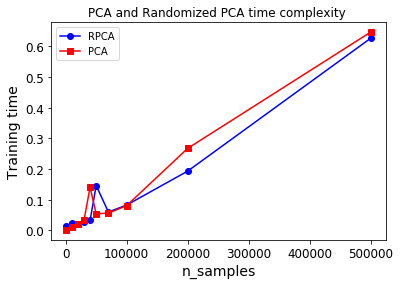

In [53]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

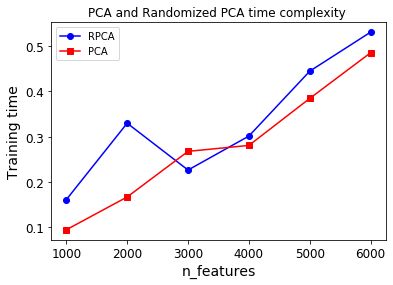

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernal PCA

In [55]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [56]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
x_reduced = rbf_pca.fit_transform(X)

/home/ephyan/.local/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


Saving figure kernel_pca_plot


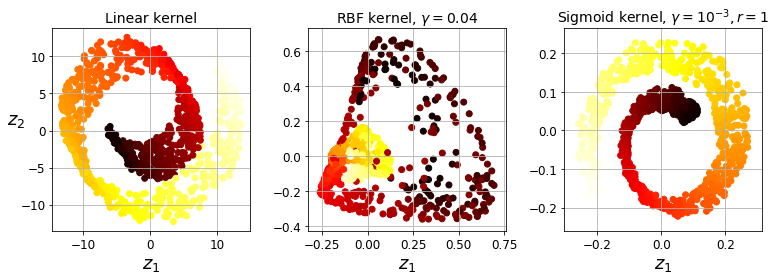

In [57]:
# the direction of first two pca is opposite with the nb due to the sign?

from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9
plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
        
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)  
    
save_fig("kernel_pca_plot")
plt.show()

Saving figure preimage_plot


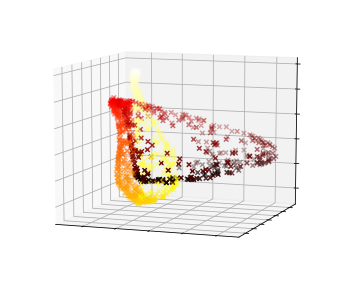

In [58]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X[:, 2], c=t, cmap=plt.cm.hot, marker='x')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

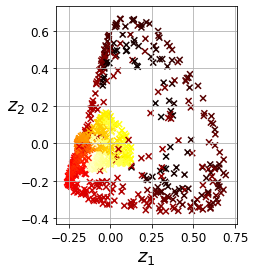

In [59]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)), 
    ('log_reg', LogisticRegression(solver="liblinear"))
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10), 
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [61]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [62]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduces = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [63]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576616

# LLE

In [64]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [65]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


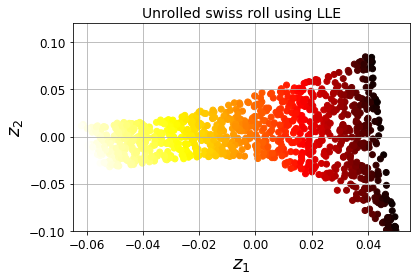

In [66]:
plt.title('Unrolled swiss roll using LLE', fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

# MDS, Isomap and t-SNE

In [67]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [68]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [69]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [70]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist['data']
y_mnist = mnist['target']
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/home/ephyan/.local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Saving figure other_dim_reduction_plot


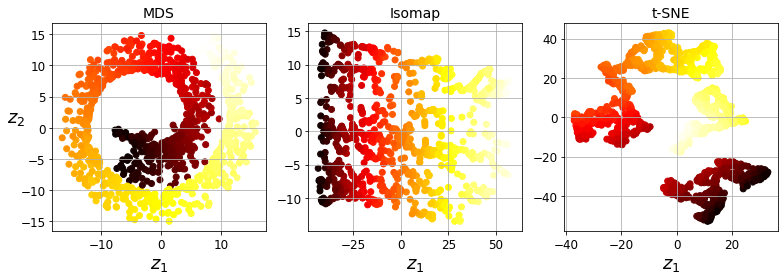

In [71]:
titles = ['MDS', 'Isomap', 't-SNE']

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    plt.grid(True)    
    
save_fig("other_dim_reduction_plot")
plt.show()

In [72]:
def learned_parameters(model):
    return [m for m in dir(model) if m.endswith('_') and not m.startswith('_')]

# External Material - Clustering
## Introduction - Classification vs Clustering

In [73]:
from sklearn.datasets import load_iris

In [74]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_diagram


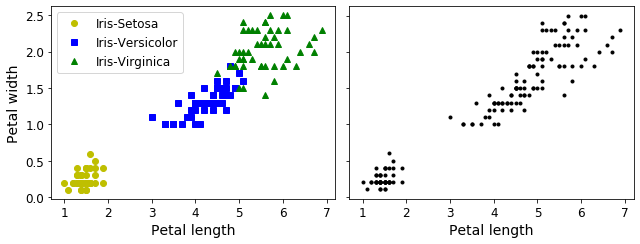

In [75]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c='k', marker='.')
plt.xlabel('Petal length', fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_diagram")
plt.show()

In [76]:
from sklearn.mixture import GaussianMixture

In [77]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

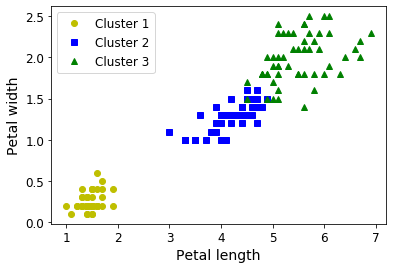

In [78]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [79]:
np.sum(y_pred == y)

145

In [80]:
np.sum(y_pred == y) / len(y_pred)

0.9666666666666667

## K-Means

In [81]:
from sklearn.datasets import make_blobs

In [82]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]]
)

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [83]:
X, y = make_blobs(n_samples=2000, centers=blob_centers, 
                  cluster_std=blob_std, random_state=7)

In [84]:
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14, rotation=0)

Saving figure blobs_diagram


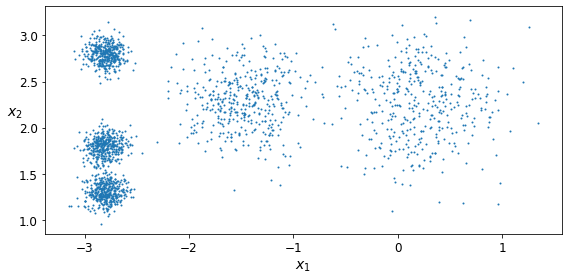

In [85]:
plt.figure(figsize=(8, 4))
plot_cluster(X)
save_fig("blobs_diagram")
plt.show()

### Fit and Predict

In [86]:
from sklearn.cluster import KMeans

In [87]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [88]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [89]:
y_pred is kmeans.labels_

True

In [90]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [91]:
# index of the cluster that the instance get assigned to
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [92]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

### Decision Boundaries

In [93]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], 
                marker='o', s=30, linewidth=8, 
                color=circle_color, zorder=10, alpha=0.9)
    # plot the x marker in the center of the centroids
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundary(clusterer, X, resolution=1000, show_centroids=True, 
                           show_xlabels=None, show_ylabels=None):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), 
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), 
                 cmap='Pastel2')  # contour fill
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), 
                 linewidths=1, colors='k')  # contour line
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel('$x_2$', fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_diagram


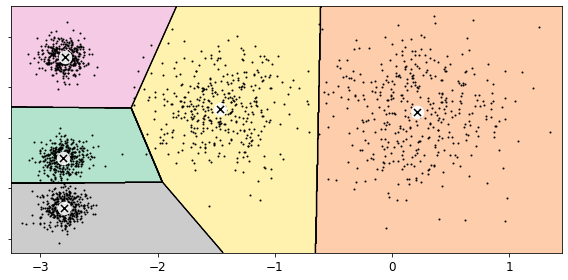

In [94]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(kmeans, X)
save_fig("voronoi_diagram")
plt.show()

### Hard Clustering *vs* Soft Clustering

In [95]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [96]:
# verify this indeed the Euclidian distance
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### K-Means Algorithm

In [97]:
kmeans_iter1 = KMeans(n_clusters=5, init='random', n_init=1, 
                      algorithm='full', max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init='random', n_init=1, 
                      algorithm='full', max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init='random', n_init=1, 
                      algorithm='full', max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

Saving figure kmeans_algorithm_diagram


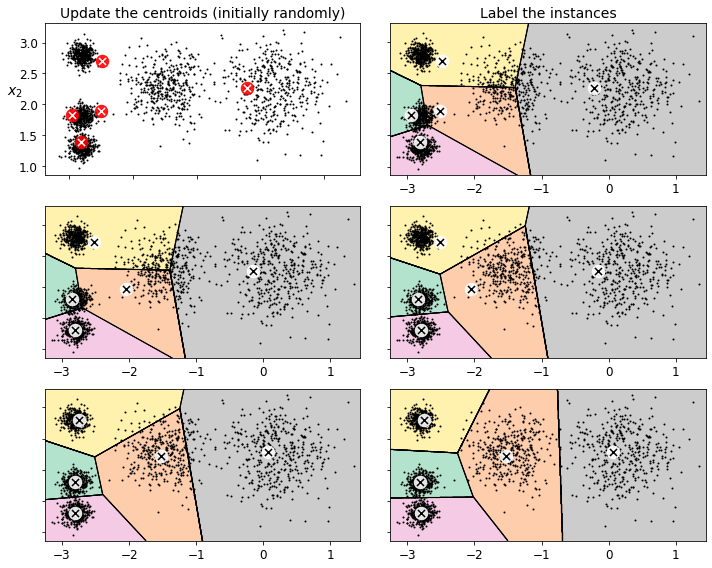

In [98]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundary(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundary(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundary(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundary(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundary(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_diagram")
plt.show()


### K-Means Variability

In [99]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)
    
    plt.figure(figsize=(10, 3.2))
    
    plt.subplot(121)
    plot_decision_boundary(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)
    
    plt.subplot(122)
    plot_decision_boundary(clusterer2, X)
    if title2:
        plt.title(title2, fontsize=14)    

Saving figure kmeans_variability_diagram


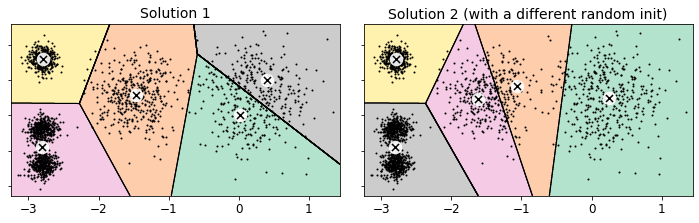

In [100]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init='random', n_init=1, 
                          algorithm='full', random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init='random', n_init=1, 
                          algorithm='full', random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X, 
                          'Solution 1', 'Solution 2 (with a different random init)')

save_fig('kmeans_variability_diagram')
plt.show()

### Inertia

To select the best model, since clustering is an unsupervised task, we measure the distance between each instance and its centroid. This is the idea behind the *inertia* metric:

In [101]:
kmeans.inertia_

211.5985372581684

In [102]:
# Verify inertia is the sum of squared distances between each training instance and its centroid
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816845

In [103]:
kmeans.score(X)

-211.59853725816845

###  Multiple Initializations

One approach is to run K-Means multiple times and select the solution that minimizes the inertia. 

In [104]:
kmeans_rnd_init1.inertia_

223.29108572819035

In [105]:
kmeans_rnd_init2.inertia_

237.46249169442848

In [106]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init='random', n_init=10, 
                             algorithm='full', random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

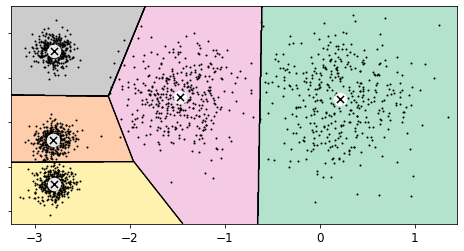

In [107]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

- Take one centroid $c_1$, chosen uniformly at random from the dataset
- Tke a new centroid $c_i$, chosen an instance $x_i$ with probability inversely proportional to $D(x_i)^2$

In [108]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [109]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(init=good_init, n_init=1, n_clusters=5, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### Accelerated K-Means

The K-Means algo can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (AC < AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids.

In [110]:
%timeit -n 50 KMeans(algorithm='elkan').fit(X)

130 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [111]:
%timeit -n 50 KMeans(algorithm='full').fit(X)

172 ms ± 8.48 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini-Batch K-Means

In [112]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [113]:
minibatch_kmeans.inertia_

211.93186531476786

In [114]:
# data does not fit in memory, the simplest option is to use the memmap class
filename = 'my_mnist.data'
m, n = 50000, 28 * 28
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

In [115]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [116]:
# If the data is so large that cannot use np.memmap

def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [117]:
np.random.seed(42)

In [118]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)  # get the init centroid
    minibatch_kmeans.partial_fit(X_init)
    
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:  # evaluate on last 10 iters
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
    
    if (best_kmeans is None or 
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_): 
        best_kmeans = minibatch_kmeans

In [119]:
best_kmeans.score(X)

-211.70999744411483

In [120]:
%timeit KMeans(n_clusters=5).fit(X)

72.4 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

47.5 ms ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [122]:
# MiniBatchKMeans is much faster than KMeans, but lower performance in general, 
# and it keeps degrading as k increase
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print('\r{}/{}'.format(k, 100), end='')
    times[k-1, 0] = timeit('kmeans.fit(X)', number=10, globals=globals())
    times[k-1, 1] = timeit('minibatch_kmeans.fit(X)', number=10, globals=globals())
    inertias[k-1, 0] = kmeans.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


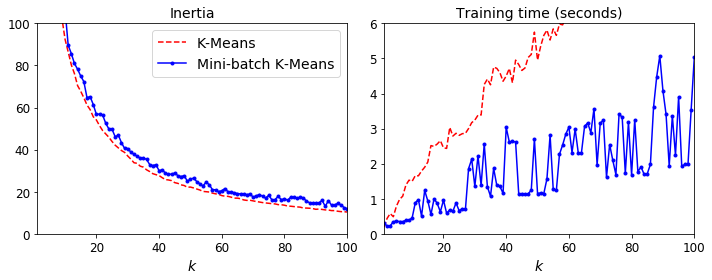

In [123]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], 'r--', label='K-Means')
plt.plot(range(1, 101), inertias[:, 1], 'b.-', label='Mini-batch K-Means')
plt.xlabel('$k$', fontsize=14)
plt.title('Inertia', fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], 'r--', label='K-Means')
plt.plot(range(1, 101), times[:, 1], 'b.-', label='Mini-batch K-Means')
plt.xlabel('$k$', fontsize=14)
plt.title('Training time (seconds)', fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig('minibatch_kmeans_vs_kmeans')
plt.show()

### Finding the optimal number of clusters

Saving figure bad_n_clusters_diagram


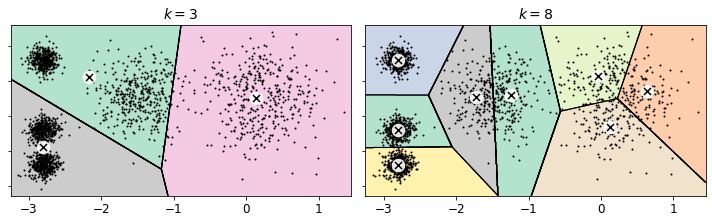

In [124]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, '$k=3$', '$k=8$')
save_fig('bad_n_clusters_diagram')
plt.show()

In [125]:
kmeans_k3.inertia_

653.2167190021553

In [126]:
kmeans_k8.inertia_

119.11983416102879

In [127]:
# We can plot the inertia as a function of k and analyze the result curve
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) 
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_diagram


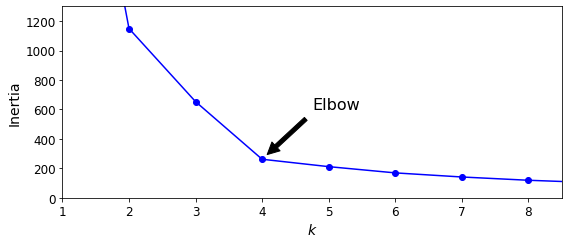

In [128]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1,10), inertias, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.annotate('Elbow', 
             xy=(4, inertias[3]), 
             xytext=(0.55, 0.55), 
             textcoords='figure fraction', 
             fontsize=16, 
             arrowprops=dict(fc='k', shrink=.1))
plt.axis([1, 8.5, 0, 1300])
save_fig('inertia_vs_k_diagram')
plt.show()

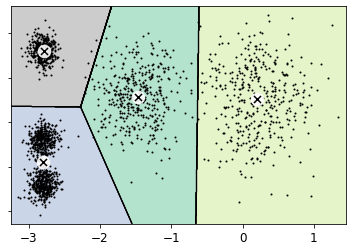

In [129]:
plot_decision_boundary(kmeans_per_k[4-1], X)
plt.show()

In [130]:
# Another approach is to look at the  sihouette score
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.34507909442492757

In [131]:
silhouette_scores = [silhouette_score(X, model.labels_) 
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_diagram


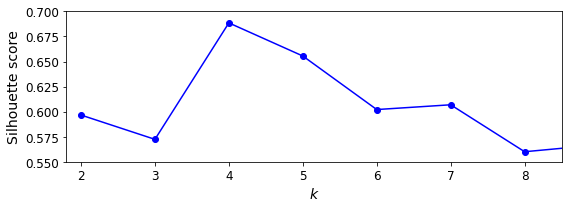

In [132]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_diagram")
plt.show()

Saving figure silhouette_analysis_diagram


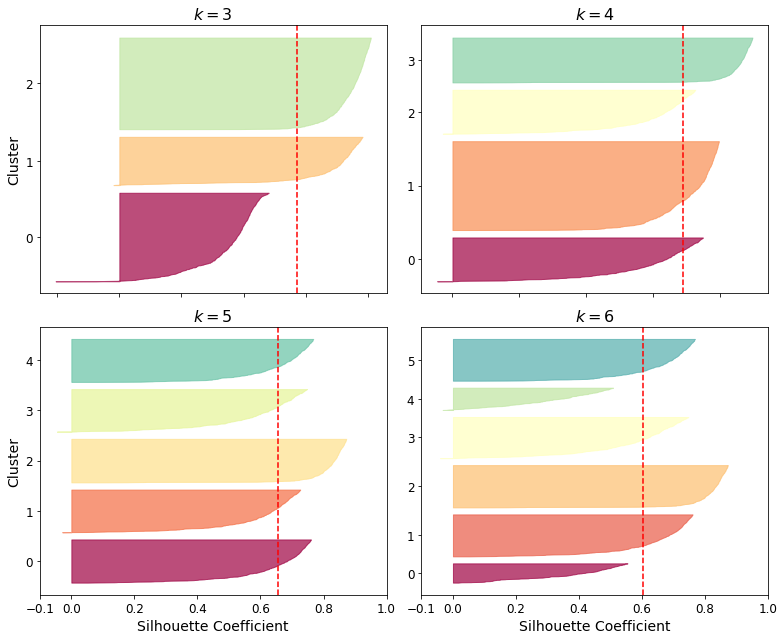

In [133]:
# An even more informative visualization is given when y ou plot every instance's silhouette coefficient
# sorted by the cluster they are assigned to and by the value of the coefficient
# This is called silhouette diagrams

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    
    padding = len(X) // 30  # the blank between silhouettes / to x axis 
    pos = padding  # initialise pos
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, 
                          fc=color, ec=color, alpha=.7)
        ticks.append(pos + len(coeffs) // 2)  # location of ticks
        pos += len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))  # Tick locations are fixed.
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))   # Set the strings manually for the labels.
    
    if k in (3, 5):
        plt.ylabel('Cluster')
        
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Silhouette Coefficient')
    else:
        plt.tick_params(labelbottom=False)
        
    plt.axvline(x=silhouette_scores[k - 2], color='r', linestyle='--')
    plt.title('$k={}$'.format(k), fontsize=16)
    
save_fig('silhouette_analysis_diagram')
plt.show()

### Limits of K-Means

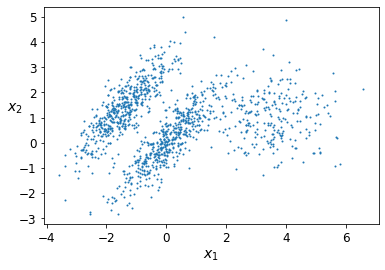

In [134]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))  # transform
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_cluster(X)

In [135]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [.5, 0], [4, 0]]), 
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Saving figure bad_kmeans_diagram


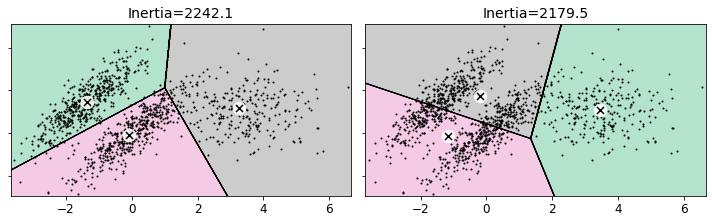

In [136]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundary(kmeans_good, X)
plt.title('Inertia={:.1f}'.format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundary(kmeans_bad, X)
plt.title('Inertia={:.1f}'.format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_diagram")
plt.show()

### Using clustering for image segmentation

In [137]:
from matplotlib.image import imread
image = imread(os.path.join('images', 'unsupervised_learning', 'ladybug.png'))
image.shape

(533, 800, 3)

In [138]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]  # broadcast the cluster centers
segmented_img = segmented_img.reshape(image.shape)

In [139]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


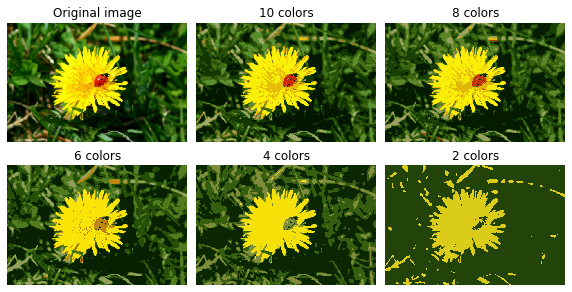

In [140]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=.05, hspace=.1)

plt.subplot(231)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title('{} colors'.format(n_clusters))
    plt.axis('off')
    
save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Using Clustering for Preprocessing

In [141]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [143]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [144]:
# Baseline, no preprocessing
log_reg.score(X_test, y_test)

0.9666666666666667

In [145]:
from sklearn.pipeline import Pipeline

# Cluster the training set into 50 clusters first
# Replace the images with their distance to the 50 clusters
# Apply a logistic regression model
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50, random_state=42)), 
    ('log_reg', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [146]:
pipeline.score(X_test, y_test)

0.9822222222222222

In [147]:
# Improvement of error rate
1 - (1 - 0.9822222) / (1 - 0.9666666)

0.4666670666658673

In [148]:
# Finding the best value of k using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kmeans__n_clusters=2, total=   0.3s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=5 ............................................
[CV] .

[CV] ............................ kmeans__n_clusters=22, total=   0.5s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   0.5s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   0.4s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.5s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.5s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.5s
[CV] kmeans__n_clusters=24 ...........................................
[CV] ............................ kmeans__n_clusters=24, total=   0.4s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   0.9s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   0.8s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.8s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.8s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.8s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.8s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.7s
[CV] kmeans__n_clusters=43 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=60, total=   1.0s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   1.0s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   1.0s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   1.0s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   1.1s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   1.2s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   1.2s
[CV] kmeans__n_clusters=63 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=80, total=   1.2s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   1.2s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   1.3s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   1.3s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   1.4s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   1.3s
[CV] kmeans__n_clusters=82 ...........................................
[CV] ............................ kmeans__n_clusters=82, total=   1.3s
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=   1.4s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   1.5s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  4.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
      

In [149]:
grid_clf.best_params_

{'kmeans__n_clusters': 90}

In [150]:
grid_clf.score(X_test, y_test)

0.9844444444444445

### Clustering for Semi-supervised Learning

In [151]:
n_labeled = 50

log_reg = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8266666666666667

In [152]:
# Cluster the training set into 50 clusters
# For each cluster, find the image closest to the centroid
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
# for each cluster find the image with min dist to centroid
representative_digit_idx = np.argmin(X_digits_dist, axis=0)  
X_representative_digits = X_train[representative_digit_idx]

Saving figure representative_images_diagram


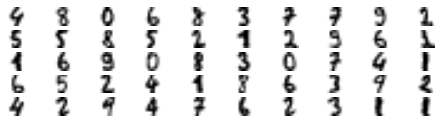

In [153]:
# Plot the 50 representative digits for the 50 clusters
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap='binary', interpolation='bilinear')
    plt.axis('off')
    
save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [154]:
# Define the label for the 50 clusters
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

In [155]:
log_reg = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

In [156]:
# If we propagate the labels to all other instances in the same cluster
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [157]:
log_reg = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9288888888888889

In [158]:
# Propagate the labels only to the instances closest to the centroid
# e.g. 20th percentile closest to the centroid
percentile_closest = 20

# fancy index, get the dist to the cluster centroid
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]  
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [159]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [160]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9422222222222222

In [161]:
# The accuracy of the propagated labels are actually pretty good
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

Further improvement:
- Manualy label the instances that the classifier is least sure about
- Train a new model with these addtional labels

## DBSCAN

In [162]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [163]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [164]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [165]:
len(dbscan.core_sample_indices_)

808

In [166]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [167]:
dbscan.components_[:3]  

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [168]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [169]:
dbscan2 = DBSCAN(eps=.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [170]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)  # initialise the mask to be False
    core_mask[dbscan.core_sample_indices_] = True  # assign the core samples to be True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)
    
    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    # Plot the core samples with same color and bigger size
    plt.scatter(cores[:, 0], cores[:, 1], 
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap='Paired')
    # Plot the core with smaller size marker
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])  
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', marker='x', s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker='.')
    if show_xlabels:
        plt.xlabel('$x_1$', fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)        
    

Saving figure dbscan_diagram


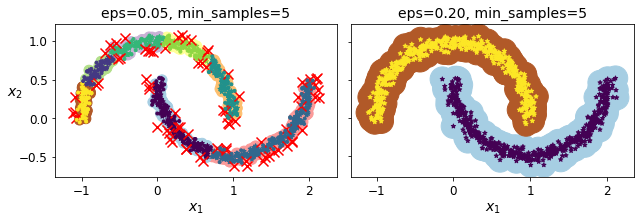

In [171]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_diagram")
plt.show()

In [172]:
dbscan = dbscan2

In [173]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [174]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [175]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_diagram


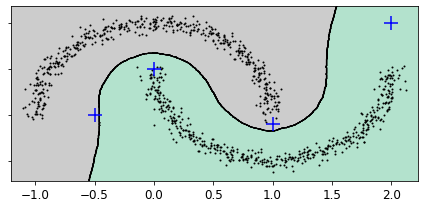

In [176]:
plt.figure(figsize=(6, 3))
plot_decision_boundary(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_diagram")
plt.show()

In [177]:
# Finds the K-neighbors of a point. Returns indices of and distances to the neighbors of each point.
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
# knn only trained on the components/core
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]  
y_pred[y_dist > .2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Other Clustering Algorithms
### Spectral CLustering

In [178]:
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=100,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=42)

In [179]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=42)

In [180]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [181]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], s=size, c='gray', marker='o', alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], s=30, c='w', marker='o')
    plt.scatter(X[:, 0], X[:, 1], s=10, c=sc.labels_, marker='o', cmap='Paired')
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)    

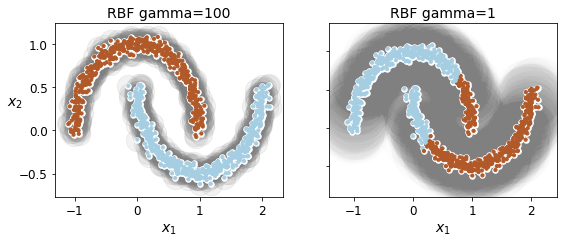

In [182]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

### Agglomerative Clustering

In [183]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage='complete').fit(X)

In [184]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_components_',
 'n_connected_components_',
 'n_leaves_']

In [185]:
agg.children_  # shape: (n - 1, 2). The 

array([[0, 1],
       [2, 3],
       [4, 5]])

In [186]:
agg.labels_

array([1, 1, 0, 0])

## Gaussian Mixtures

In [187]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))  # transformation
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]  # translation
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [188]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [189]:
gm.weights_

array([0.20965228, 0.4000662 , 0.39028152])

In [190]:
gm.means_

array([[ 3.39909717,  1.05933727],
       [-1.40763984,  1.42710194],
       [ 0.05135313,  0.07524095]])

In [191]:
gm.covariances_

array([[[ 1.14807234, -0.03270354],
        [-0.03270354,  0.95496237]],

       [[ 0.63478101,  0.72969804],
        [ 0.72969804,  1.1609872 ]],

       [[ 0.68809572,  0.79608475],
        [ 0.79608475,  1.21234145]]])

In [192]:
gm.converged_

True

In [193]:
gm.n_iter_

4

In [194]:
gm.predict(X)

array([2, 2, 1, ..., 0, 0, 0])

In [195]:
gm.predict_proba(X)

array([[2.32389467e-02, 6.77397850e-07, 9.76760376e-01],
       [1.64685609e-02, 6.75361303e-04, 9.82856078e-01],
       [2.01535333e-06, 9.99923053e-01, 7.49319577e-05],
       ...,
       [9.99999571e-01, 2.13946075e-26, 4.28788333e-07],
       [1.00000000e+00, 1.46454409e-41, 5.12459171e-16],
       [1.00000000e+00, 8.02006365e-41, 2.27626238e-15]])

In [196]:
X_new, y_new = gm.sample(6)
X_new

array([[ 2.95400315,  2.63680992],
       [-1.16654575,  1.62792705],
       [-1.39477712, -1.48511338],
       [ 0.27221525,  0.690366  ],
       [ 0.54095936,  0.48591934],
       [ 0.38064009, -0.56240465]])

In [197]:
y_new

array([0, 1, 2, 2, 2, 2])

In [198]:
gm.score_samples(X)

array([-2.60782346, -3.57106041, -3.33003479, ..., -3.51352783,
       -4.39802535, -3.80743859])

In [199]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999217849

In [200]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - .1
    maxs = X.max(axis=0) + .1
    
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), 
                         np.linspace(mins[1], maxs[1], resolution))
    Z = - clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='--')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)
    
    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_diagram


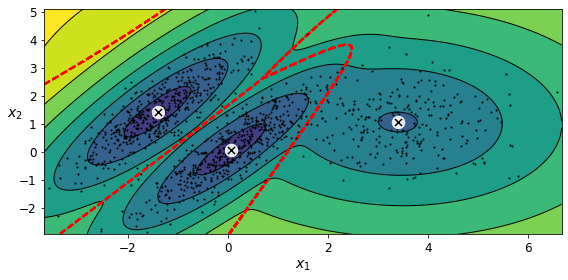

In [201]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_diagram")
plt.show()

Values of **convariance_type** hyperparameter:
- 'full': default, no constraint
- 'tied': all clusters must have the same shape (they all share the same convariance matrix)
- 'sperical': all clusters must be spherical, but they can have different diameters
- 'diag': clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to axes (covariance matrix must be diag)

In [202]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [203]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

Saving figure covariance_type_diagram


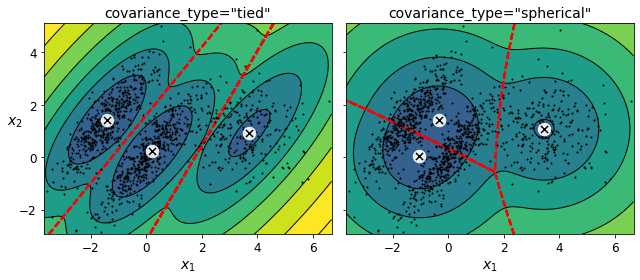

In [204]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_diagram")
plt.show()

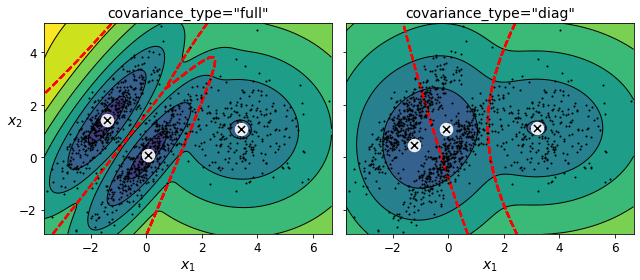

In [205]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### Anomaly Detection using Gaussian Mixtures
Instances located in low-density regions can be considered anomalies.

In [206]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_diagram


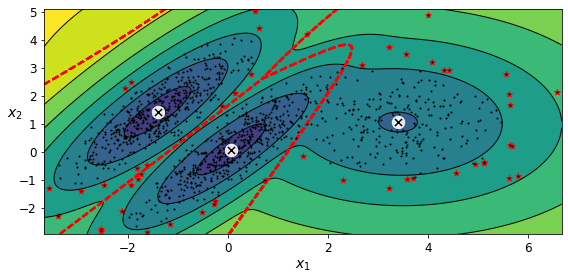

In [207]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_diagram")
plt.show()

### Model Selection

We cannot use inertia or silhouette score as they both assume that the clusters are spherical. We can try to find the model that minimizes a theoretical information criterion s.t. Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC):

$BIC = log(m)p - 2log(\hat L)$

$AIC = 2p - 2log(\hat L)$
- $m$ is the number of instances
- $p$ is the number of parameters learned by the model
- $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observaed data $\matrix X$

Both AIC and BIC penalize models that have more parameters to learn (e.g. more clusters), and reward models that fit the data well (i.e. models that give a high likelihood to the observed data.)

In [208]:
gm.bic(X)

8189.74345832983

In [209]:
gm.aic(X)

8102.518178214792

In [210]:
# Compute the bic manually
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1  # weights for each cluster
n_params_for_means = n_clusters * n_dims  # center of each cluster
n_params_for_convariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_convariance
max_log_likelihood = gm.score(X) * len(X)  #log(L^)  # gm.score(X): per-sample avg log-likelihood of X
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [211]:
bic, aic

(8189.74345832983, 8102.518178214792)

In [212]:
n_params

17

In [213]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X) 
             for k in range(1, 11)]

In [214]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure aic_bic_vs_k_diagram


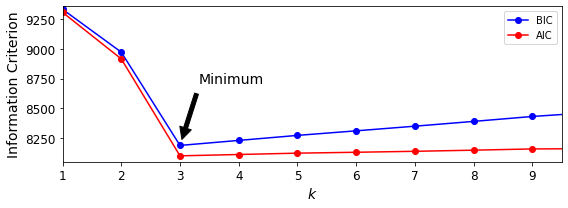

In [215]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, 'bo-', label='BIC')
plt.plot(range(1, 11), aics, 'ro-', label='AIC')
plt.legend()
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum', xy=(3, bics[2]), 
             xytext=(.35, .6), 
             textcoords='figure fraction', 
             fontsize=14, 
             arrowprops=dict(fc='k', shrink=.1))
save_fig("aic_bic_vs_k_diagram")
plt.show()

In [216]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [217]:
best_k

3

In [218]:
best_covariance_type

'full'

### Variational Bayesian Gaussian Mixtures
Bayesian Gaussian Mixture:
- automatically set the weights to be zero to unnecessary clusters
- set the n_component to the number > than optimal number of clusters

In [219]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, random_state=42, n_init=10)
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [220]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

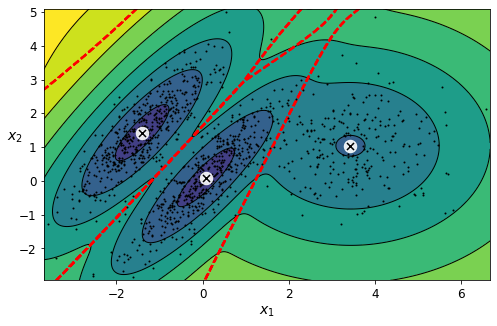

In [221]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [222]:
# Different weight concentration
bgm_low = BayesianGaussianMixture(n_components=10, n_init=1, max_iter=1000, 
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, n_init=1, max_iter=1000, 
                                  weight_concentration_prior=10000, random_state=42)
nn=73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

In [223]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [224]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

Saving figure mixture_concentration_prior_diagram


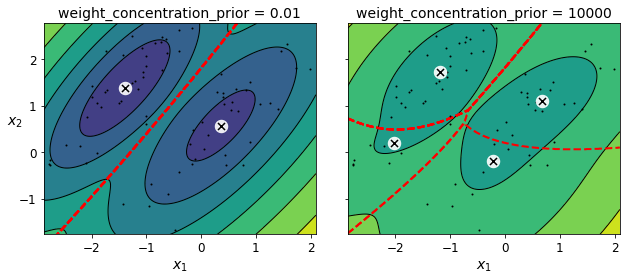

In [225]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_diagram")
plt.show()

**Note:** This is not a bug that right diagram shows 4 regions instead of 3. The right top cluster has much greater weights than the bottom right cluster. So the probability that any given point in this region belongs t the top right is greater than the probability it belongs to the bottom rihgt cluster

In [226]:
X_moons, y_moons = make_moons(n_samples=1000, noise=.05, random_state=42)

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

Saving figure moons_vs_bgm_diagram


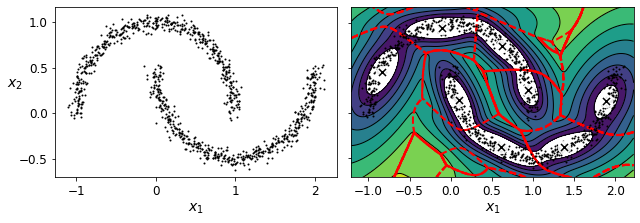

In [227]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_diagram")
plt.show()

**Note:** The algo detects 8 ellipsoidal cluster instead of 2, but density plot is not too bad.

## Likelihood Function

In [228]:
from scipy.stats import norm

xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)  #pdf(x, loc, scale)
ZZ = ZZ / ZZ.sum(axis=1) / (xx[1] - xx[0])  # Normalise, likelihood fucntion

Saving figure Likelihood_function_diagram


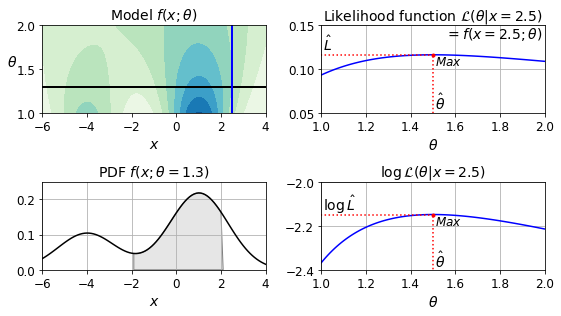

In [229]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85  # x = 2.5
s_idx = 30  # theta = 1.3

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap='GnBu')
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], 'k-', lw=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], 'b-', lw=2)
plt.xlabel(r'$x$')
plt.ylabel(r'$\theta$', fontsize=14, rotation=0)
plt.title(r'Model $f(x; \theta)$', fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], 'b-')
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, 'r.')
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], 'r:')
plt.plot([0, ss[max_idx]], [max_val, max_val], 'r:')
plt.text(1.01, max_val + 0.005, r'$\hat{L}$', fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r'Likelihood function $\mathcal{L}(\theta|x=2.5)$', fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], 'k-')
plt.axis([-6, 4, 0, .25])
plt.xlabel(r'$x$', fontsize=14)
plt.grid(True)
plt.title(r'PDF $f(x; \theta=1.3)$', fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[81], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), 'b-')
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, 'r.')
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], 'r:')
plt.plot([0, ss[max_idx]], [max_val, max_val], 'r:')
plt.text(1.01, max_val + 0.02, r'$\log\, \hat{L}$', fontsize=14)
plt.text(ss[max_idx] + 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx] + 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.title(r'$\log\, \mathcal{L}(\theta|x=2.5)$', fontsize=14)

save_fig('Likelihood_function_diagram')
plt.show()

# Exercise Solutions

## Q1. 
What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

The main motivations for dimensionality reduction are:
- To speed up a subsquent training algorithm (in some cases it may even remove noise and redundent features, making the training algo perform better).
- To visualise the data and gain insights on the most important features.
- Simply to save space (compression).

The main drawbacks are:
- information loss, probably degrade the performance of subsequent algorithms
- can be computationally intensive
- adds some complexity to ML pipelines
- transformed features are often hard to interpret.

## Q2. 
What is the curse of dimensionality?

The curse of dimensionality refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space. In ML, one common manifestation is the fact that randomly sampled high-dimensional vectors are generally very sparse, increasing the risk of overfitting and making it very difficult to identify patterns in the data without having plenty of training data.

## Q3.
Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

Almost impossible to perfectly reverse the operation, because some information get lost during dimensionality reduction. MOreover, while some algorithm (s.t. PCA) have a simple reverse transformation procedure that can reconstruct a dataset  relatively similar to the original, other algorithms (s.t. T-SNE) do not.

## Q4.
Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

PCA can be used to significantly reduce the dimensionality fo most dataset, even if they are highly nonlinear, because it can at least get rid of useless dimensions. However, if there are no useless dimensions, e.g. the Swiss roll, then reducing dimensionality with PCA will lose too much information. You want to unroll the Swiss roll instead of squash it.

## Q5.
Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?

Depends on the dataset. Look at two extreme examples. First suppose the data set composed of points that are almost perfectly aligned. In this case, PCA can reduce the dataset down to just one dimension while still preserving 95% of the variance. Now imagine that the dataset is composed of perfectly random points, scattered all around 1000 dimensions. In this all 1000 dimensions are required to preserved 95% of the variance.

So it could be any number between 1 and 1000. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the daatset's intrinsic dimensionality.

## Q6.
In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?

Regular PCA is default, but it works only if the dataset fits in memory. Incremental PCA is useful for large datasets that don't fit in memory, but it is slower than regular PCA, sor if the dataset fit in memory, it is prefered to use regular PCA. Incremental PCA is also useful for online tasks, when you need to apply PCA on the fly, every time a new instance arrives.

Randomised PCA is useful when you want to considerable reduce dimensionality and the dataset fit in memory, in this case, it is much faster than regular PCA.

Kernal PCA is useful for nonlinear datasets.

## Q7.
How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

A dimension reduction algorithm performs will if it eliminates a lots of dimensions without losing too much information. One way to measure this is to apply the reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. Alternatively, if  you are using dimension reduction as a preprocessing step before another ML algo, you can simply measure the performancce of that second algo; if the dimension reduction did not lose too much information, then the algorithem should perform just as well as when using the original dataset.

## Q8.
Does it make any sense to chain two different dimensionality reduction algorithms?

Yes, a common example is using PCA to get rid of a large number of useless dimensions, the applying another much slower dimensionality reduction alogrithm, such as LLE. This two-step approach will likely yield the same performance as using LLE only BUT in a fraction of the time.

## Q9.

Exercise: Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [230]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [231]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [232]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

print('Training took {:.2f}s'.format(t1 - t0))

Training took 5.85s


In [233]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9492

In [234]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95)
X_train_reduced = pca.fit_transform(X_train)

In [235]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print('Training took {:.2f}s'.format(t1 - t0))

Training took 15.61s


Noted that the training takes longer time
dimension reduction does not always lead to faster training time
it depends on the dataset, the model and the training algorithm.

In [237]:
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

In [238]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

print('Training took {:.2f}s'.format(t1 - t0))

Training took 45.36s


/home/ephyan/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [239]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [240]:
log_clf2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("Training took {:.2f}s".format(t1 - t0))

Training took 22.05s


/home/ephyan/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [242]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

## Q10.

Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.

In [255]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [245]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

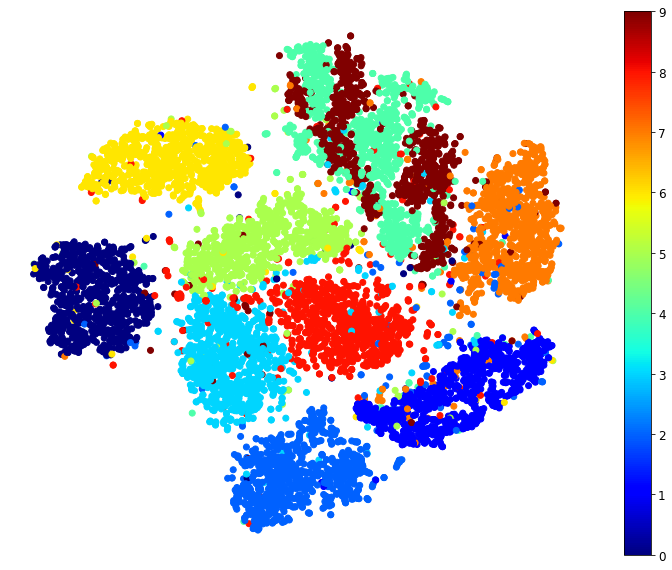

In [247]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

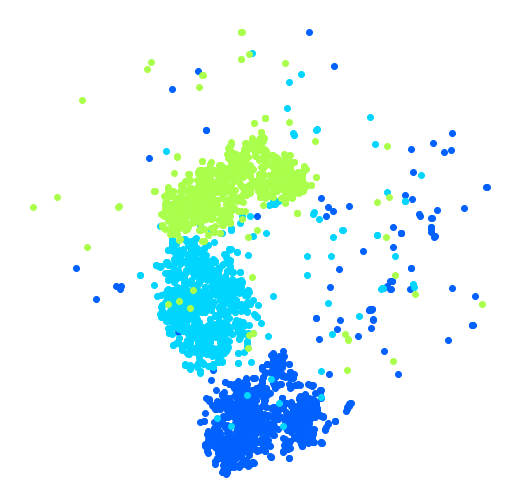

In [248]:
# Focus on 3 and 5

plt.figure(figsize=(9, 9))
cmap = mpl.cm.get_cmap('jet')
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit/9)])

plt.axis('off')
plt.show()

In [249]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

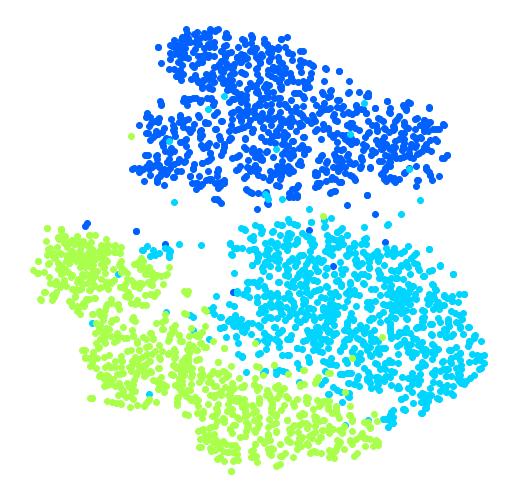

In [250]:
plt.figure(figsize=(9, 9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], 
                X_subset_reduced[y_subset == digit, 1], 
                c=[cmap(digit / 9)])

plt.axis('off')
plt.show()

In [256]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Scale the input features so that they range from 0 to 1
    X_normalised = MinMaxScaler().fit_transform(X)
    # Create the list of coordinates of the digits plotted so far
    neighbors = np.array([[10., 10.]])
    
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap('jet')
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalised[y == digit, 0], X_normalised[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis('off')
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalised):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])), 
                         color=cmap(y[index]/9), fontdict={'size': 16, 'weight': 'bold'})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap='binary'), image_coord)
                ax.add_artist(imagebox)

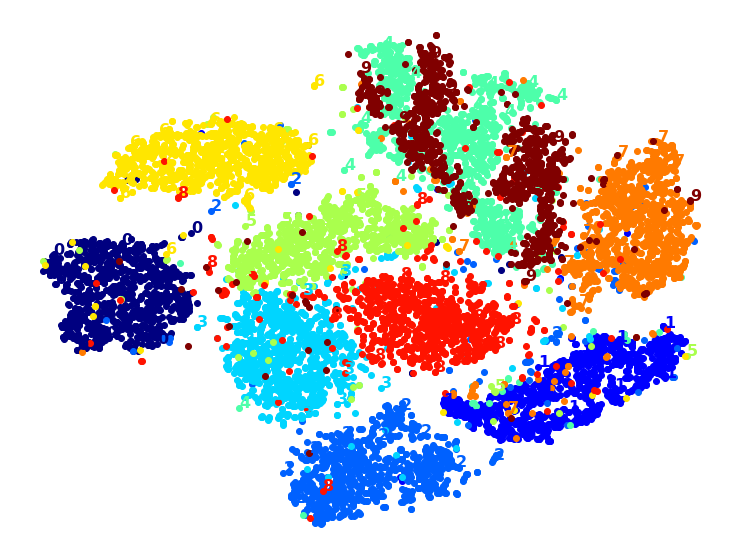

In [258]:
plot_digits(X_reduced, y)

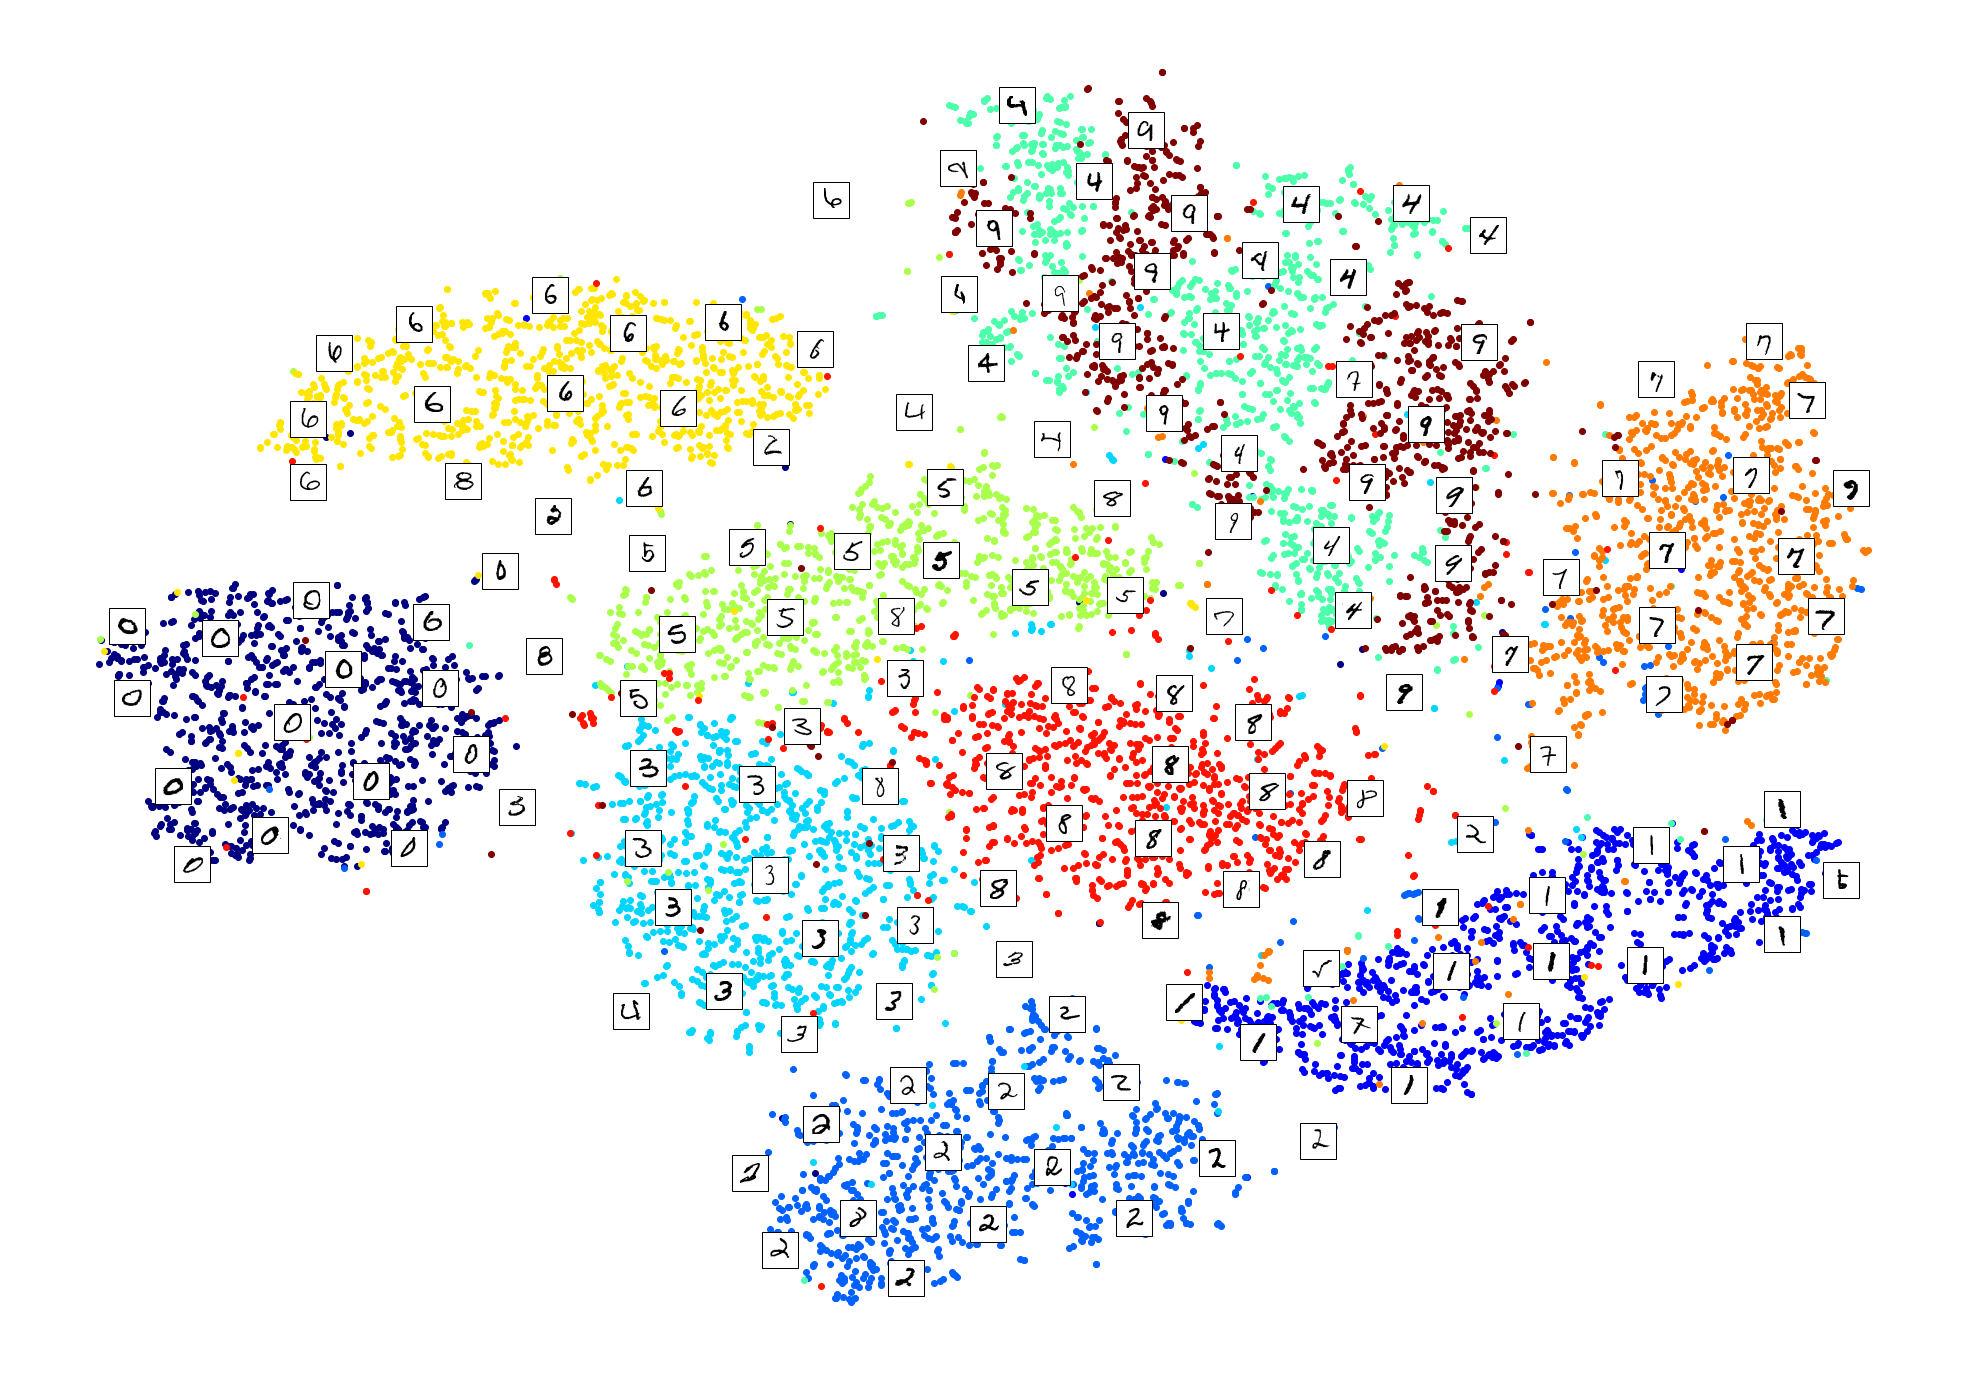

In [261]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

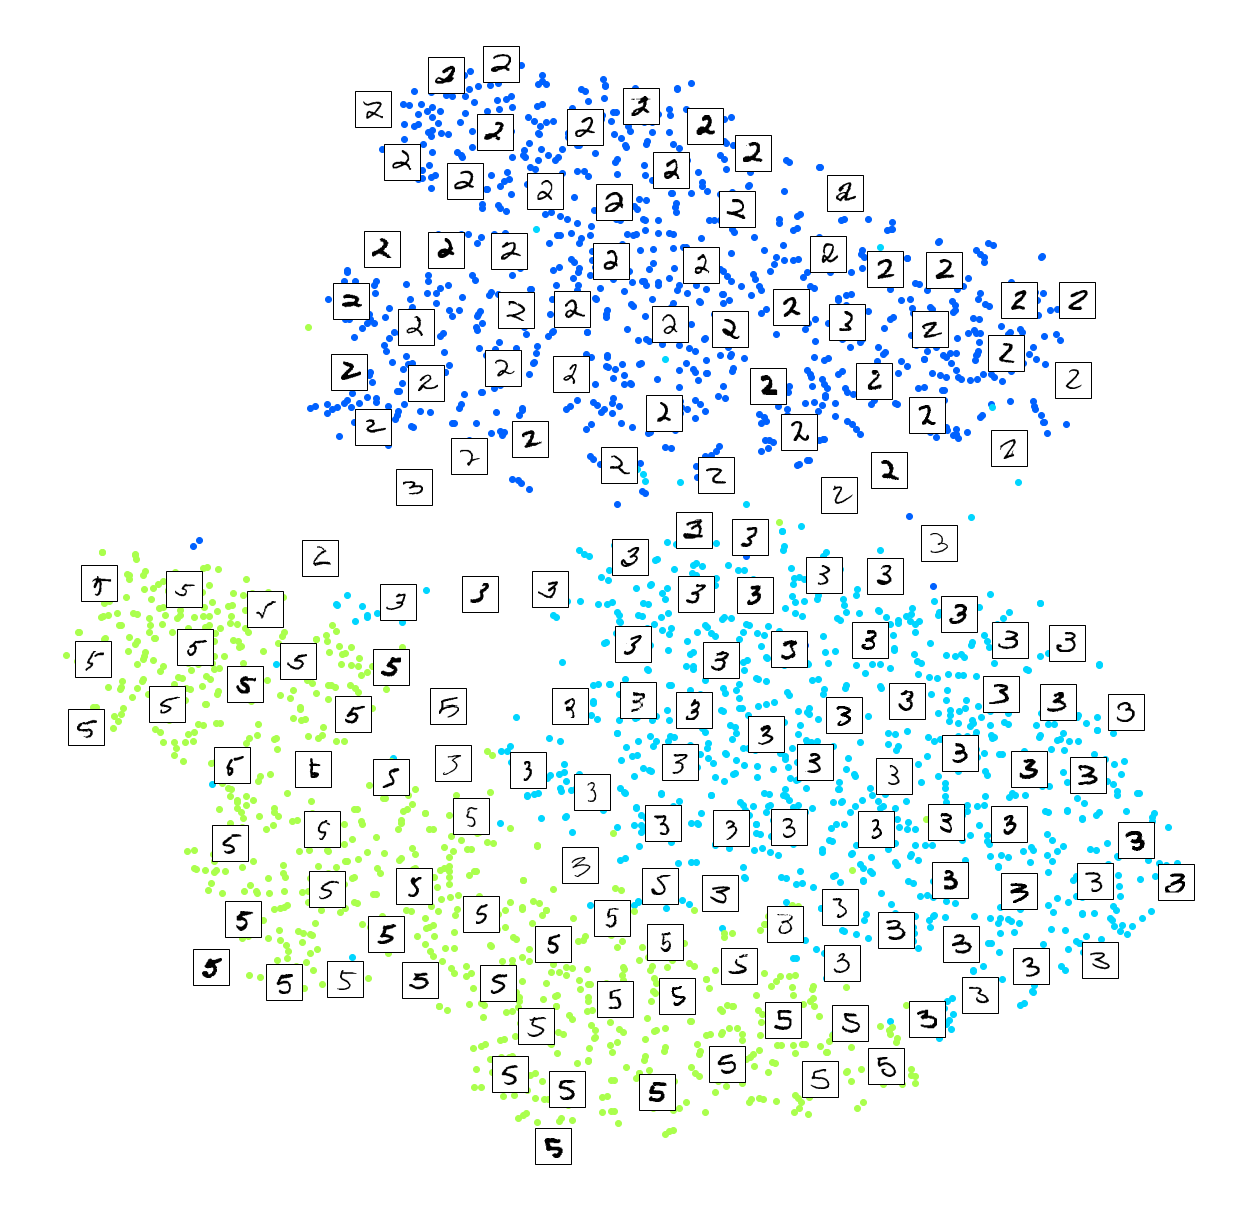

In [262]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA took 0.8s.


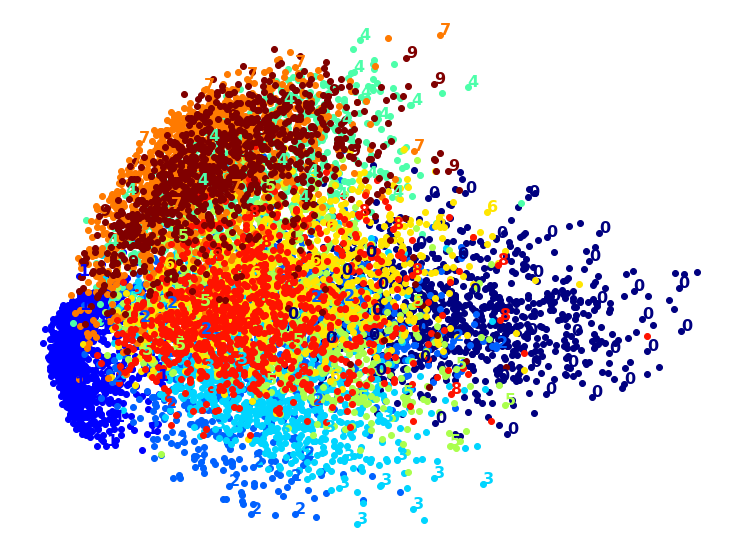

In [263]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

LLE took 410.7s.


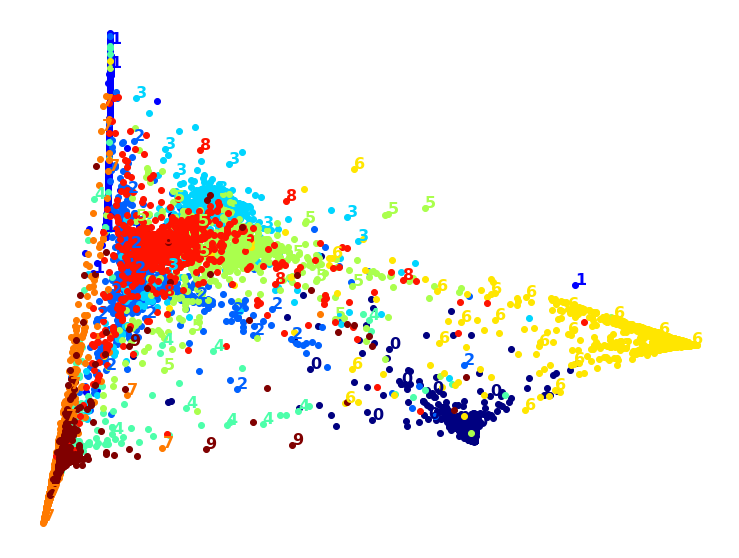

In [264]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

PCA+LLE took 137.1s.


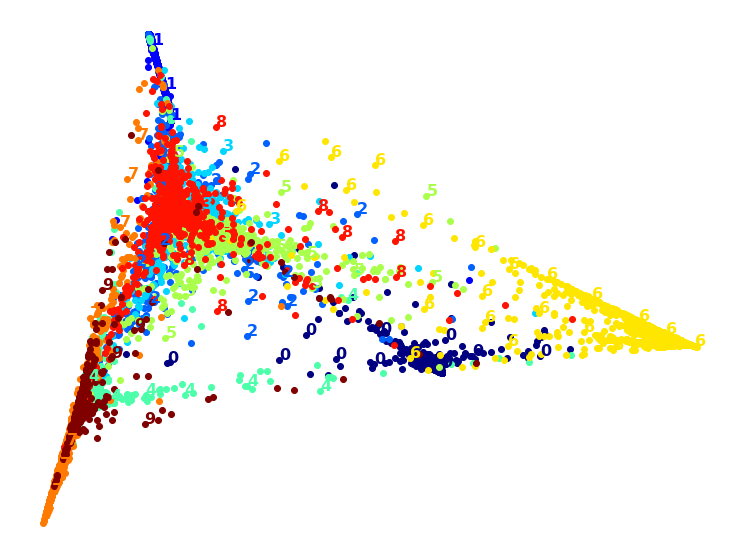

In [265]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)), 
    ('lle', LocallyLinearEmbedding(n_components=2, random_state=42))
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

MDS took 168.4s (on just 2,000 MNIST images instead of 10,000).


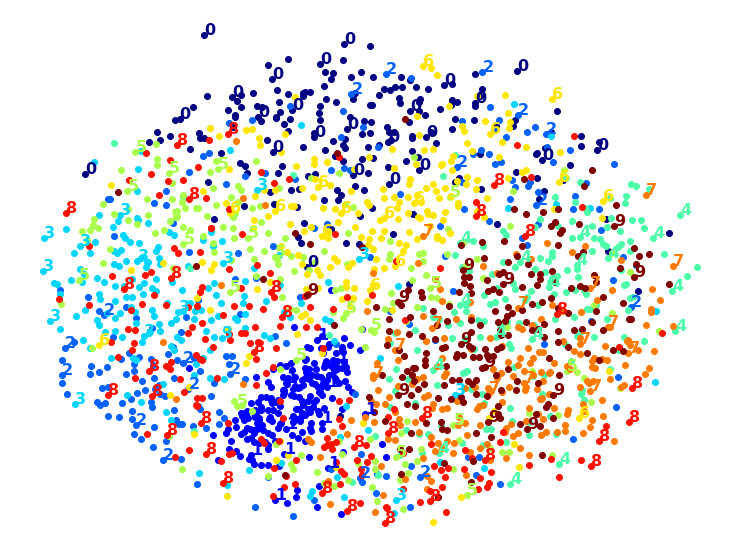

In [266]:
from sklearnearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_componentsrangeandom_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

PCA+MDS took 180.0s (on 2,000 MNIST images).


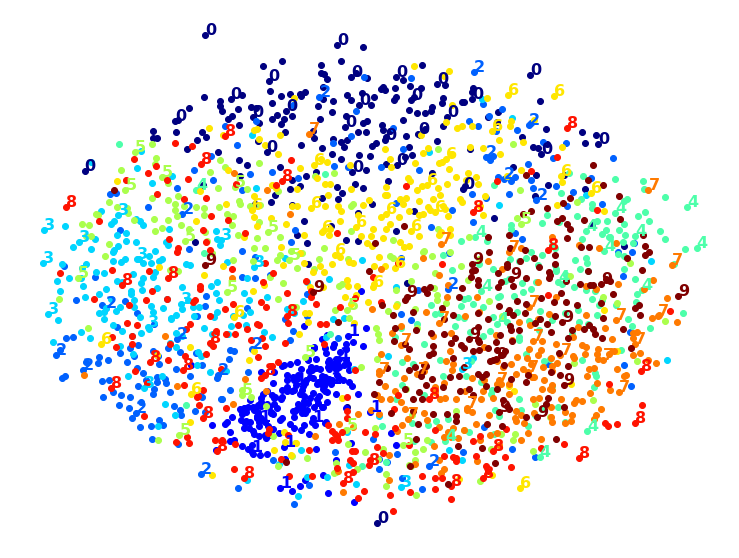

In [267]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)), 
    ('mds', MDS(n_components=2, random_state=42))])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

/home/ephyan/.local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA took 6.1s.


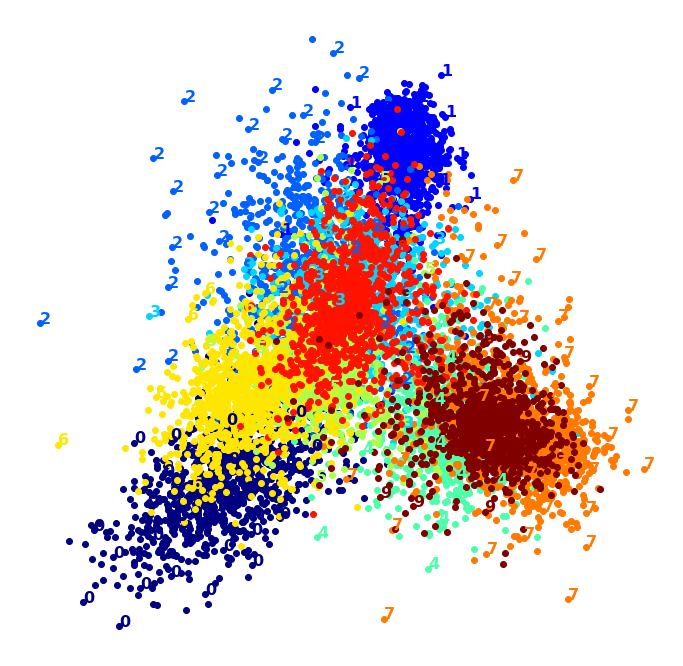

In [271]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

t-SNE took 517.8s.


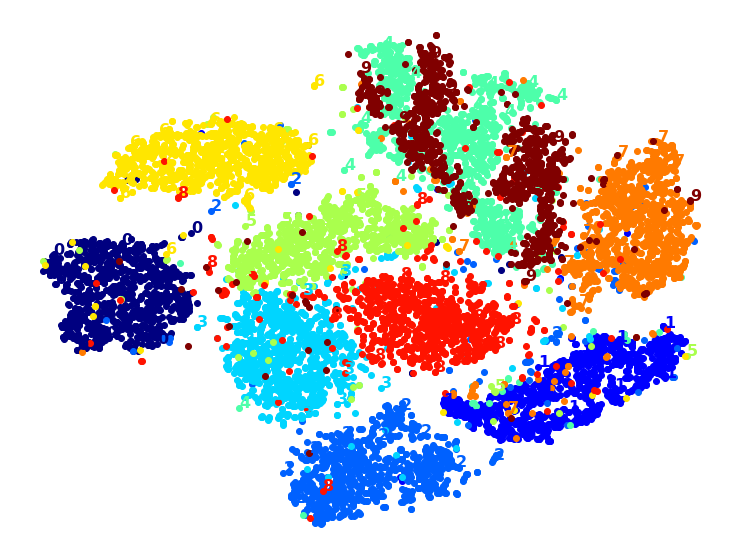

In [272]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

PCA+t-SNE took 265.5s.


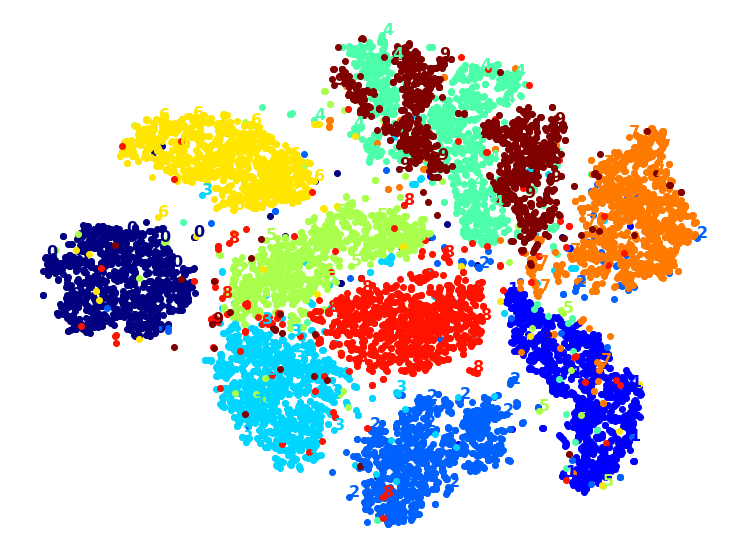

In [273]:
from sklearn.pipeline import Pipeline

pca_tsne = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)), 
    ('tsne', TSNE(n_components=2, random_state=42))])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()